In [1]:
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim

import joblib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from get_api_keys import get_secret
import numpy as np
import anndata as ad
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, f1_score
from tqdm import tqdm
from clearml import Logger
import clearml
from clearml import Task

In [ ]:
adata_main = ad.read_h5ad('DATA/GSE155249_main.h5ad')

### 1. We are going to select our architecture based on the Classifier results on validation data

### 2. We are going to use only highly variable genes to speed up computations

In [3]:
adata = adata_main[:, adata_main.var['highly_variable'] == True]
print(f"Adata shape: {adata.shape}")
print(f"Adata main shape: {adata_main.shape}")

Adata shape: (77146, 4488)
Adata main shape: (77146, 21819)


### Setting up ClearML to track experiment results

In [2]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
os.environ["CLEARML_API_ACCESS_KEY"] = get_secret("CLEARML_API_ACCESS_KEY")
os.environ["CLEARML_API_SECRET_KEY"] = get_secret("CLEARML_API_SECRET_KEY")

clearml.browser_login()

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml


### Load train and val data (prepared in different notebook)

In [ ]:
train = np.load("DATA/train_data.npz")
X_train, y_train = train["X"], train["y"]

val = np.load("DATA/val_data.npz")
X_val, y_val = val["X"], val["y"]

label_encoder = joblib.load('DATA/label_encoder.pkl')

In [6]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (54002, 4488), y_train shape: (54002,)
X_val shape: (15429, 4488), y_val shape: (15429,)


### Prepare Torch Datasets and DataLoaders

In [ ]:
class scRNAseqDataset(data.Dataset):

    def __init__(self, data, labels):
        super().__init__()
        self.data = data
        self.label = labels

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [8]:
train_dataset = scRNAseqDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_dataset = scRNAseqDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

train_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=128, shuffle=True)

In [9]:
class RNAseqClassifier(nn.Module):
    def __init__(self, input_size, layer_config, output_size):
        """
        Parameters:
        - input_size (int): Number of input features (genes)
        - layer_config (list[dict]): List of layer definitions. Each dict should have:
            - 'size' (int): Hidden layer size
            - 'batchnorm' (bool): Whether to apply BatchNorm
            - 'dropout' (float or None): Dropout rate
        - output_size (int): Number of output classes
        """
        super().__init__()

        layers = []
        in_dim = input_size

        for cfg in layer_config:
            out_dim = cfg["size"]
            layers.append(nn.Linear(in_dim, out_dim))

            if cfg.get("batchnorm", False):
                layers.append(nn.BatchNorm1d(out_dim))

            layers.append(nn.ReLU())

            if cfg.get("dropout") is not None:
                layers.append(nn.Dropout(cfg["dropout"]))

            in_dim = out_dim

        # Final classification layer
        layers.append(nn.Linear(in_dim, output_size))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [10]:
def compute_metrics(preds, targets, prefix, epoch, task, model_name):
    """
    Computes and logs classification metrics to ClearML.

    Parameters:
        preds (list or np.array): Predicted class labels
        targets (list or np.array): True class labels
        prefix (str): Either "Train" or "Validation"
        epoch (int): Epoch number for ClearML logging
        task (clearml.Task): ClearML Task object
        model_name (str): Name of the model being evaluated
    """
    acc = accuracy_score(targets, preds)
    prec = precision_score(targets, preds, average='macro', zero_division=0)
    f1 = f1_score(targets, preds, average='macro', zero_division=0)

    logger = task.get_logger()
    logger.report_scalar(f"Accuracy_{prefix}", model_name, iteration=epoch, value=acc)
    logger.report_scalar(f"Precision_{prefix}", model_name, iteration=epoch, value=prec)
    logger.report_scalar(f"F1_{prefix}", model_name, iteration=epoch, value=f1)

    return {"acc": acc, "prec": prec, "f1": f1}

In [11]:
def train_model(model, model_name, train_loader, val_loader, optimizer, num_epochs, device, task):
    """
    Trains the model and logs metrics to ClearML.

    Parameters:
        model (nn.Module): PyTorch model
        model_name (str): Name of the model for logging
        train_loader (DataLoader): Training data loader
        val_loader (DataLoader): Validation data loader
        optimizer (torch.optim.Optimizer): Optimizer
        num_epochs (int): Number of training epochs
        device (torch.device): CUDA or CPU
        task (clearml.Task): Active ClearML task
    """

    criterion = nn.CrossEntropyLoss()
    model.to(device)

    # ---- Initial validation before training ----
    model.eval()
    initial_preds, initial_targets = [], []

    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc="Initial Validation"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            initial_preds.extend(preds.cpu().numpy())
            initial_targets.extend(targets.cpu().numpy())

    compute_metrics(initial_preds, initial_targets, prefix="Val", epoch=0, task=task, model_name=model_name)

    # ---- Training loop ----
    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0
        train_preds, train_targets = [], []

        pbar = tqdm(train_loader, desc=f"{model_name} | Epoch {epoch}/{num_epochs} [Train]")
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_targets.extend(targets.cpu().numpy())

        # Log training loss
        task.get_logger().report_scalar("Loss_Train", model_name, iteration=epoch, value=train_loss / len(train_loader.dataset))
        train_metrics = compute_metrics(train_preds, train_targets, prefix="Train", epoch=epoch, task=task, model_name=model_name)

        # ---- Validation ----
        model.eval()
        val_loss = 0.0
        val_preds, val_targets = [], []

        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [Val]")
            for inputs, targets in pbar:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)

                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())

        # Log validation loss
        task.get_logger().report_scalar("Loss_Val", model_name, iteration=epoch, value=val_loss / len(val_loader.dataset))
        val_metrics = compute_metrics(val_preds, val_targets, prefix="Val", epoch=epoch, task=task, model_name=model_name)

        # Print epoch summary
        print(
            f"Epoch {epoch}/{num_epochs} | "
            f"Train Acc: {train_metrics['acc']:.4f} | Val Acc: {val_metrics['acc']:.4f} | "
            f"Train F1: {train_metrics['f1']:.4f} | Val F1: {val_metrics['f1']:.4f}"
        )


In [14]:
def predict_sample(model, sample, device, label_encoder):

    model.eval()

    if not isinstance(sample, torch.Tensor):
        sample = torch.tensor(sample, dtype=torch.float32)
    
    sample = sample.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(sample)
        pred_idx = torch.argmax(output, dim=1).item()
        pred_label = label_encoder.inverse_transform([pred_idx])[0]

    return pred_idx, pred_label

In [16]:
models_to_test = [
    RNAseqClassifier(
        input_size=X_train.shape[1],
        layer_config=[
            {"size": 512, "batchnorm": True, "dropout": 0.5},
            {"size": 256, "batchnorm": True, "dropout": 0.5},
            {"size": 128, "batchnorm": True, "dropout": None}
        ],
        output_size=len(np.unique(y_train))
    ),
    RNAseqClassifier(
        input_size=X_train.shape[1],
        layer_config=[
            {"size": 512, "batchnorm": False, "dropout": None},
            {"size": 256, "batchnorm": False, "dropout": None},
            {"size": 128, "batchnorm": False, "dropout": None}
        ],
        output_size=len(np.unique(y_train))
    ),
    RNAseqClassifier(
        input_size=X_train.shape[1],
        layer_config = [
            {"size": 256, "batchnorm": True, "dropout": 0.3},
            {"size": 128, "batchnorm": True, "dropout": 0.3},
            {"size": 64, "batchnorm": True, "dropout": None}
        ],
        output_size=len(np.unique(y_train))
    ),
    RNAseqClassifier(
        input_size=X_train.shape[1],
        layer_config = [
            {"size": 128, "batchnorm": True, "dropout": 0.2},
            {"size": 64, "batchnorm": True, "dropout": 0.2}
        ],
        output_size=len(np.unique(y_train))
    ),
    RNAseqClassifier(
        input_size=X_train.shape[1],
        layer_config=[
            {"size": 1024, "batchnorm": True, "dropout": 0.5},
            {"size": 512, "batchnorm": True, "dropout": 0.5},
            {"size": 256, "batchnorm": True, "dropout": 0.5},
            {"size": 128, "batchnorm": True, "dropout": None}
        ],
        output_size=len(np.unique(y_train))
    )
]

In [17]:
task = Task.init(project_name='Modelling', task_name='Hyperparameter Tuning')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i, model in enumerate(models_to_test):
    print(f"Training model {i + 1}/{len(models_to_test)}")
    model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    train_model(
        model=model,
        model_name=f"Model_{i + 1}",
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        num_epochs=10,
        device=DEVICE,
        task=task
    )

    print(f"Model {i + 1} training complete.")

ClearML Task: created new task id=a04fad835234420f885a3719f156586d
2025-05-25 11:57:52,843 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/e7ad8385c3454c3f88f0353baedffffb/experiments/a04fad835234420f885a3719f156586d/output/log
Training model 1/5


Initial Validation: 100%|██████████| 121/121 [00:01<00:00, 77.70it/s]
Model_1 | Epoch 1/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 269.18it/s]
Epoch 1/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 597.96it/s]
Model_1 | Epoch 2/10 [Train]:   6%|▋         | 27/422 [00:00<00:01, 261.81it/s]

Epoch 1/10 | Train Acc: 0.5743 | Val Acc: 0.7600 | Train F1: 0.2503 | Val F1: 0.4250


Model_1 | Epoch 2/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 254.47it/s]
Epoch 2/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 638.00it/s]
Model_1 | Epoch 3/10 [Train]:   6%|▌         | 26/422 [00:00<00:01, 251.00it/s]

Epoch 2/10 | Train Acc: 0.7749 | Val Acc: 0.8446 | Train F1: 0.4800 | Val F1: 0.6432


Model_1 | Epoch 3/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 258.05it/s]
Epoch 3/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 626.53it/s]
Model_1 | Epoch 4/10 [Train]:   6%|▌         | 25/422 [00:00<00:01, 241.47it/s]

Epoch 3/10 | Train Acc: 0.8554 | Val Acc: 0.8691 | Train F1: 0.6660 | Val F1: 0.7217


Model_1 | Epoch 4/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 247.30it/s]
Epoch 4/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 626.47it/s]
Model_1 | Epoch 5/10 [Train]:   6%|▋         | 27/422 [00:00<00:01, 263.06it/s]

Epoch 4/10 | Train Acc: 0.8929 | Val Acc: 0.8776 | Train F1: 0.7417 | Val F1: 0.7550


Model_1 | Epoch 5/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 264.07it/s]
Epoch 5/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 605.04it/s]
Model_1 | Epoch 6/10 [Train]:   6%|▋         | 27/422 [00:00<00:01, 269.87it/s]

Epoch 5/10 | Train Acc: 0.9156 | Val Acc: 0.8760 | Train F1: 0.7734 | Val F1: 0.7565


Model_1 | Epoch 6/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 252.66it/s]
Epoch 6/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 573.21it/s]
Model_1 | Epoch 7/10 [Train]:   6%|▋         | 27/422 [00:00<00:01, 266.40it/s]

Epoch 6/10 | Train Acc: 0.9333 | Val Acc: 0.8750 | Train F1: 0.7905 | Val F1: 0.7579


Model_1 | Epoch 7/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 258.04it/s]
Epoch 7/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 623.66it/s]
Model_1 | Epoch 8/10 [Train]:   6%|▋         | 27/422 [00:00<00:01, 266.61it/s]

Epoch 7/10 | Train Acc: 0.9446 | Val Acc: 0.8769 | Train F1: 0.8013 | Val F1: 0.7611


Model_1 | Epoch 8/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 256.42it/s]
Epoch 8/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 633.20it/s]
Model_1 | Epoch 9/10 [Train]:   7%|▋         | 28/422 [00:00<00:01, 269.95it/s]

Epoch 8/10 | Train Acc: 0.9558 | Val Acc: 0.8744 | Train F1: 0.8175 | Val F1: 0.7843


Model_1 | Epoch 9/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 259.04it/s]
Epoch 9/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 609.61it/s]
Model_1 | Epoch 10/10 [Train]:   6%|▋         | 27/422 [00:00<00:01, 266.51it/s]

Epoch 9/10 | Train Acc: 0.9621 | Val Acc: 0.8745 | Train F1: 0.8510 | Val F1: 0.8256


Model_1 | Epoch 10/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 259.02it/s]
Initial Validation: 100%|██████████| 121/121 [00:00<00:00, 679.55it/s]

Epoch 10/10 | Train Acc: 0.9706 | Val Acc: 0.8732 | Train F1: 0.8920 | Val F1: 0.8527
Model 1 training complete.
Training model 2/5



Model_2 | Epoch 1/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 328.68it/s]
Epoch 1/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 657.83it/s]
Model_2 | Epoch 2/10 [Train]:   9%|▉         | 40/422 [00:00<00:00, 392.98it/s]

Epoch 1/10 | Train Acc: 0.7450 | Val Acc: 0.8760 | Train F1: 0.5692 | Val F1: 0.7728


Model_2 | Epoch 2/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 376.50it/s]
Epoch 2/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 665.70it/s]
Model_2 | Epoch 3/10 [Train]:   8%|▊         | 33/422 [00:00<00:01, 323.02it/s]

Epoch 2/10 | Train Acc: 0.9204 | Val Acc: 0.8825 | Train F1: 0.8853 | Val F1: 0.8656


Model_2 | Epoch 3/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 327.86it/s]
Epoch 3/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 652.24it/s]
Model_2 | Epoch 4/10 [Train]:   8%|▊         | 32/422 [00:00<00:01, 315.08it/s]

Epoch 3/10 | Train Acc: 0.9557 | Val Acc: 0.8819 | Train F1: 0.9531 | Val F1: 0.8774


Model_2 | Epoch 4/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 307.95it/s]
Epoch 4/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 647.04it/s]
Model_2 | Epoch 5/10 [Train]:   8%|▊         | 34/422 [00:00<00:01, 330.18it/s]

Epoch 4/10 | Train Acc: 0.9783 | Val Acc: 0.8805 | Train F1: 0.9798 | Val F1: 0.8777


Model_2 | Epoch 5/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 303.56it/s]
Epoch 5/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 661.92it/s]
Model_2 | Epoch 6/10 [Train]:   7%|▋         | 31/422 [00:00<00:01, 300.74it/s]

Epoch 5/10 | Train Acc: 0.9917 | Val Acc: 0.8807 | Train F1: 0.9925 | Val F1: 0.8829


Model_2 | Epoch 6/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 298.99it/s]
Epoch 6/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 653.10it/s]
Model_2 | Epoch 7/10 [Train]:   8%|▊         | 32/422 [00:00<00:01, 319.86it/s]

Epoch 6/10 | Train Acc: 0.9979 | Val Acc: 0.8815 | Train F1: 0.9984 | Val F1: 0.8848


Model_2 | Epoch 7/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 311.80it/s]
Epoch 7/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 663.37it/s]
Model_2 | Epoch 8/10 [Train]:  10%|▉         | 41/422 [00:00<00:00, 402.39it/s]

Epoch 7/10 | Train Acc: 0.9996 | Val Acc: 0.8813 | Train F1: 0.9998 | Val F1: 0.8853


Model_2 | Epoch 8/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 321.64it/s]
Epoch 8/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 671.17it/s]
Model_2 | Epoch 9/10 [Train]:   7%|▋         | 30/422 [00:00<00:01, 295.12it/s]

Epoch 8/10 | Train Acc: 1.0000 | Val Acc: 0.8804 | Train F1: 1.0000 | Val F1: 0.8840


Model_2 | Epoch 9/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 303.07it/s]
Epoch 9/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 663.62it/s]
Model_2 | Epoch 10/10 [Train]:   7%|▋         | 30/422 [00:00<00:01, 298.72it/s]

Epoch 9/10 | Train Acc: 1.0000 | Val Acc: 0.8814 | Train F1: 1.0000 | Val F1: 0.8829


Model_2 | Epoch 10/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 309.86it/s]
Initial Validation: 100%|██████████| 121/121 [00:00<00:00, 656.35it/s]

Epoch 10/10 | Train Acc: 1.0000 | Val Acc: 0.8814 | Train F1: 1.0000 | Val F1: 0.8824
Model 2 training complete.
Training model 3/5



Model_3 | Epoch 1/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 271.38it/s]
Epoch 1/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 628.60it/s]
Model_3 | Epoch 2/10 [Train]:   6%|▌         | 26/422 [00:00<00:01, 254.62it/s]

Epoch 1/10 | Train Acc: 0.5932 | Val Acc: 0.7608 | Train F1: 0.2992 | Val F1: 0.4254


Model_3 | Epoch 2/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 264.19it/s]
Epoch 2/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 617.70it/s]
Model_3 | Epoch 3/10 [Train]:   6%|▋         | 27/422 [00:00<00:01, 261.57it/s]

Epoch 2/10 | Train Acc: 0.7717 | Val Acc: 0.8265 | Train F1: 0.4448 | Val F1: 0.5481


Model_3 | Epoch 3/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 260.22it/s]
Epoch 3/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 654.41it/s]
Model_3 | Epoch 4/10 [Train]:   6%|▌         | 26/422 [00:00<00:01, 250.57it/s]

Epoch 3/10 | Train Acc: 0.8442 | Val Acc: 0.8579 | Train F1: 0.5881 | Val F1: 0.6572


Model_3 | Epoch 4/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 261.27it/s]
Epoch 4/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 646.38it/s]
Model_3 | Epoch 5/10 [Train]:   6%|▋         | 27/422 [00:00<00:01, 269.22it/s]

Epoch 4/10 | Train Acc: 0.8918 | Val Acc: 0.8699 | Train F1: 0.6907 | Val F1: 0.7144


Model_3 | Epoch 5/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 277.00it/s]
Epoch 5/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 641.85it/s]
Model_3 | Epoch 6/10 [Train]:   6%|▌         | 26/422 [00:00<00:01, 251.35it/s]

Epoch 5/10 | Train Acc: 0.9196 | Val Acc: 0.8735 | Train F1: 0.7551 | Val F1: 0.7507


Model_3 | Epoch 6/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 269.34it/s]
Epoch 6/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 649.41it/s]
Model_3 | Epoch 7/10 [Train]:   6%|▋         | 27/422 [00:00<00:01, 260.10it/s]

Epoch 6/10 | Train Acc: 0.9376 | Val Acc: 0.8746 | Train F1: 0.7891 | Val F1: 0.7583


Model_3 | Epoch 7/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 267.37it/s]
Epoch 7/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 640.00it/s]
Model_3 | Epoch 8/10 [Train]:   6%|▌         | 26/422 [00:00<00:01, 255.32it/s]

Epoch 7/10 | Train Acc: 0.9519 | Val Acc: 0.8728 | Train F1: 0.8067 | Val F1: 0.7591


Model_3 | Epoch 8/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 269.73it/s]
Epoch 8/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 646.91it/s]
Model_3 | Epoch 9/10 [Train]:   6%|▋         | 27/422 [00:00<00:01, 260.45it/s]

Epoch 8/10 | Train Acc: 0.9621 | Val Acc: 0.8699 | Train F1: 0.8172 | Val F1: 0.7572


Model_3 | Epoch 9/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 280.05it/s]
Epoch 9/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 633.18it/s]
Model_3 | Epoch 10/10 [Train]:   9%|▉         | 37/422 [00:00<00:01, 360.63it/s]

Epoch 9/10 | Train Acc: 0.9687 | Val Acc: 0.8730 | Train F1: 0.8278 | Val F1: 0.7720


Model_3 | Epoch 10/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 350.46it/s]
Initial Validation: 100%|██████████| 121/121 [00:00<00:00, 666.62it/s]

Epoch 10/10 | Train Acc: 0.9755 | Val Acc: 0.8702 | Train F1: 0.8432 | Val F1: 0.7879
Model 3 training complete.
Training model 4/5



Model_4 | Epoch 1/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 312.68it/s]
Epoch 1/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 684.70it/s]
Model_4 | Epoch 2/10 [Train]:   8%|▊         | 32/422 [00:00<00:01, 314.72it/s]

Epoch 1/10 | Train Acc: 0.6061 | Val Acc: 0.7818 | Train F1: 0.3692 | Val F1: 0.5319


Model_4 | Epoch 2/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 310.03it/s]
Epoch 2/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 648.15it/s]
Model_4 | Epoch 3/10 [Train]:   8%|▊         | 33/422 [00:00<00:01, 327.54it/s]

Epoch 2/10 | Train Acc: 0.7972 | Val Acc: 0.8373 | Train F1: 0.5701 | Val F1: 0.6542


Model_4 | Epoch 3/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 299.02it/s]
Epoch 3/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 674.65it/s]
Model_4 | Epoch 4/10 [Train]:   8%|▊         | 32/422 [00:00<00:01, 310.77it/s]

Epoch 3/10 | Train Acc: 0.8597 | Val Acc: 0.8675 | Train F1: 0.6921 | Val F1: 0.7274


Model_4 | Epoch 4/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 312.75it/s]
Epoch 4/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 668.68it/s]
Model_4 | Epoch 5/10 [Train]:   8%|▊         | 32/422 [00:00<00:01, 313.17it/s]

Epoch 4/10 | Train Acc: 0.8944 | Val Acc: 0.8743 | Train F1: 0.7506 | Val F1: 0.7506


Model_4 | Epoch 5/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 313.63it/s]
Epoch 5/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 636.59it/s]
Model_4 | Epoch 6/10 [Train]:   7%|▋         | 29/422 [00:00<00:01, 288.46it/s]

Epoch 5/10 | Train Acc: 0.9139 | Val Acc: 0.8741 | Train F1: 0.7777 | Val F1: 0.7529


Model_4 | Epoch 6/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 307.97it/s]
Epoch 6/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 683.64it/s]
Model_4 | Epoch 7/10 [Train]:  10%|▉         | 41/422 [00:00<00:00, 405.77it/s]

Epoch 6/10 | Train Acc: 0.9295 | Val Acc: 0.8724 | Train F1: 0.7956 | Val F1: 0.7566


Model_4 | Epoch 7/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 414.04it/s]
Epoch 7/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 663.98it/s]
Model_4 | Epoch 8/10 [Train]:   7%|▋         | 30/422 [00:00<00:01, 290.27it/s]

Epoch 7/10 | Train Acc: 0.9447 | Val Acc: 0.8721 | Train F1: 0.8110 | Val F1: 0.7686


Model_4 | Epoch 8/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 292.87it/s]
Epoch 8/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 687.03it/s]
Model_4 | Epoch 9/10 [Train]:   9%|▉         | 40/422 [00:00<00:00, 394.02it/s]

Epoch 8/10 | Train Acc: 0.9530 | Val Acc: 0.8693 | Train F1: 0.8308 | Val F1: 0.7677


Model_4 | Epoch 9/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 401.33it/s]
Epoch 9/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 664.95it/s]
Model_4 | Epoch 10/10 [Train]:   9%|▉         | 38/422 [00:00<00:01, 375.95it/s]

Epoch 9/10 | Train Acc: 0.9611 | Val Acc: 0.8685 | Train F1: 0.8346 | Val F1: 0.7943


Model_4 | Epoch 10/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 319.08it/s]
Initial Validation:  50%|█████     | 61/121 [00:00<00:00, 607.15it/s]

Epoch 10/10 | Train Acc: 0.9682 | Val Acc: 0.8656 | Train F1: 0.8579 | Val F1: 0.7906
Model 4 training complete.
Training model 5/5


Initial Validation: 100%|██████████| 121/121 [00:00<00:00, 607.47it/s]
Model_5 | Epoch 1/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 217.71it/s]
Epoch 1/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 620.52it/s]
Model_5 | Epoch 2/10 [Train]:   6%|▌         | 25/422 [00:00<00:01, 246.95it/s]

Epoch 1/10 | Train Acc: 0.5188 | Val Acc: 0.7280 | Train F1: 0.2085 | Val F1: 0.3639


Model_5 | Epoch 2/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 252.91it/s]
Epoch 2/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 616.40it/s]
Model_5 | Epoch 3/10 [Train]:   5%|▍         | 21/422 [00:00<00:01, 207.92it/s]

Epoch 2/10 | Train Acc: 0.7296 | Val Acc: 0.8007 | Train F1: 0.3774 | Val F1: 0.4987


Model_5 | Epoch 3/10 [Train]: 100%|██████████| 422/422 [00:02<00:00, 205.32it/s]
Epoch 3/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 615.60it/s]
Model_5 | Epoch 4/10 [Train]:   5%|▍         | 21/422 [00:00<00:01, 201.51it/s]

Epoch 3/10 | Train Acc: 0.8202 | Val Acc: 0.8447 | Train F1: 0.5394 | Val F1: 0.6241


Model_5 | Epoch 4/10 [Train]: 100%|██████████| 422/422 [00:02<00:00, 200.91it/s]
Epoch 4/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 601.72it/s]
Model_5 | Epoch 5/10 [Train]:   7%|▋         | 28/422 [00:00<00:01, 272.02it/s]

Epoch 4/10 | Train Acc: 0.8778 | Val Acc: 0.8726 | Train F1: 0.6801 | Val F1: 0.7419


Model_5 | Epoch 5/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 230.46it/s]
Epoch 5/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 619.39it/s]
Model_5 | Epoch 6/10 [Train]:   7%|▋         | 28/422 [00:00<00:01, 271.58it/s]

Epoch 5/10 | Train Acc: 0.9160 | Val Acc: 0.8758 | Train F1: 0.7607 | Val F1: 0.7563


Model_5 | Epoch 6/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 268.52it/s]
Epoch 6/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 616.64it/s]
Model_5 | Epoch 7/10 [Train]:   7%|▋         | 28/422 [00:00<00:01, 271.39it/s]

Epoch 6/10 | Train Acc: 0.9348 | Val Acc: 0.8743 | Train F1: 0.7837 | Val F1: 0.7566


Model_5 | Epoch 7/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 217.49it/s]
Epoch 7/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 601.76it/s]
Model_5 | Epoch 8/10 [Train]:   6%|▌         | 25/422 [00:00<00:01, 246.66it/s]

Epoch 7/10 | Train Acc: 0.9477 | Val Acc: 0.8721 | Train F1: 0.7994 | Val F1: 0.7545


Model_5 | Epoch 8/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 235.27it/s]
Epoch 8/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 581.66it/s]
Model_5 | Epoch 9/10 [Train]:   5%|▌         | 22/422 [00:00<00:01, 219.38it/s]

Epoch 8/10 | Train Acc: 0.9603 | Val Acc: 0.8721 | Train F1: 0.8110 | Val F1: 0.7571


Model_5 | Epoch 9/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 215.69it/s]
Epoch 9/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 606.78it/s]
Model_5 | Epoch 10/10 [Train]:   6%|▌         | 24/422 [00:00<00:01, 239.85it/s]

Epoch 9/10 | Train Acc: 0.9674 | Val Acc: 0.8721 | Train F1: 0.8234 | Val F1: 0.7611


Model_5 | Epoch 10/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 248.25it/s]
Epoch 10/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 613.98it/s]


Epoch 10/10 | Train Acc: 0.9736 | Val Acc: 0.8715 | Train F1: 0.8505 | Val F1: 0.7793
Model 5 training complete.


### Training model with weight decay

In [21]:
model = RNAseqClassifier(
        input_size=X_train.shape[1],
        layer_config=[
            {"size": 512, "batchnorm": True, "dropout": 0.5},
            {"size": 256, "batchnorm": True, "dropout": 0.5},
            {"size": 128, "batchnorm": True, "dropout": None}
        ],
        output_size=len(np.unique(y_train))
    )
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

train_model(
    model=model,
    model_name="Weight_decay_Model",
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    num_epochs=10,
    device=DEVICE,
    task=task
)

Initial Validation: 100%|██████████| 121/121 [00:00<00:00, 640.00it/s]
Weight_decay_Model | Epoch 1/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 241.51it/s]
Epoch 1/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 627.98it/s]
Weight_decay_Model | Epoch 2/10 [Train]:   6%|▌         | 25/422 [00:00<00:01, 241.97it/s]

Epoch 1/10 | Train Acc: 0.5603 | Val Acc: 0.7807 | Train F1: 0.2780 | Val F1: 0.5013


Weight_decay_Model | Epoch 2/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 247.69it/s]
Epoch 2/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 635.44it/s]
Weight_decay_Model | Epoch 3/10 [Train]:   7%|▋         | 28/422 [00:00<00:01, 278.98it/s]

Epoch 2/10 | Train Acc: 0.7807 | Val Acc: 0.8375 | Train F1: 0.5019 | Val F1: 0.6128


Weight_decay_Model | Epoch 3/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 276.79it/s]
Epoch 3/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 630.23it/s]
Weight_decay_Model | Epoch 4/10 [Train]:   6%|▌         | 26/422 [00:00<00:01, 251.25it/s]

Epoch 3/10 | Train Acc: 0.8523 | Val Acc: 0.8669 | Train F1: 0.6497 | Val F1: 0.7109


Weight_decay_Model | Epoch 4/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 258.24it/s]
Epoch 4/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 634.42it/s]
Weight_decay_Model | Epoch 5/10 [Train]:   7%|▋         | 28/422 [00:00<00:01, 277.43it/s]

Epoch 4/10 | Train Acc: 0.8912 | Val Acc: 0.8755 | Train F1: 0.7380 | Val F1: 0.7485


Weight_decay_Model | Epoch 5/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 278.35it/s]
Epoch 5/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 633.30it/s]
Weight_decay_Model | Epoch 6/10 [Train]:   7%|▋         | 28/422 [00:00<00:01, 275.05it/s]

Epoch 5/10 | Train Acc: 0.9163 | Val Acc: 0.8771 | Train F1: 0.7740 | Val F1: 0.7540


Weight_decay_Model | Epoch 6/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 274.59it/s]
Epoch 6/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 629.06it/s]
Weight_decay_Model | Epoch 7/10 [Train]:   6%|▌         | 25/422 [00:00<00:01, 249.62it/s]

Epoch 6/10 | Train Acc: 0.9339 | Val Acc: 0.8757 | Train F1: 0.7921 | Val F1: 0.7571


Weight_decay_Model | Epoch 7/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 270.86it/s]
Epoch 7/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 630.11it/s]
Weight_decay_Model | Epoch 8/10 [Train]:   7%|▋         | 29/422 [00:00<00:01, 282.59it/s]

Epoch 7/10 | Train Acc: 0.9445 | Val Acc: 0.8766 | Train F1: 0.8028 | Val F1: 0.7705


Weight_decay_Model | Epoch 8/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 293.66it/s]
Epoch 8/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 632.90it/s]
Weight_decay_Model | Epoch 9/10 [Train]:   8%|▊         | 34/422 [00:00<00:01, 338.59it/s]

Epoch 8/10 | Train Acc: 0.9561 | Val Acc: 0.8774 | Train F1: 0.8257 | Val F1: 0.7960


Weight_decay_Model | Epoch 9/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 328.26it/s]
Epoch 9/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 618.06it/s]
Weight_decay_Model | Epoch 10/10 [Train]:   8%|▊         | 32/422 [00:00<00:01, 316.21it/s]

Epoch 9/10 | Train Acc: 0.9623 | Val Acc: 0.8753 | Train F1: 0.8551 | Val F1: 0.8132


Weight_decay_Model | Epoch 10/10 [Train]: 100%|██████████| 422/422 [00:01<00:00, 278.13it/s]
Epoch 10/10 [Val]: 100%|██████████| 121/121 [00:00<00:00, 586.90it/s]

Epoch 10/10 | Train Acc: 0.9695 | Val Acc: 0.8739 | Train F1: 0.8993 | Val F1: 0.8427


### Plots were downloaded from ClearML

In [ ]:
def show_images_grid(folder_path):
    image_files = sorted([
        f for f in os.listdir(folder_path)
        if f.endswith('.png')
    ])

    assert len(image_files) == 8, f"Expected 8 images, found {len(image_files)}"

    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 16))
    axes = axes.flatten()

    for ax, img_file in zip(axes, image_files):
        img_path = os.path.join(folder_path, img_file)
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(os.path.splitext(img_file)[0], fontsize=10)
        ax.axis('off')

    plt.show()

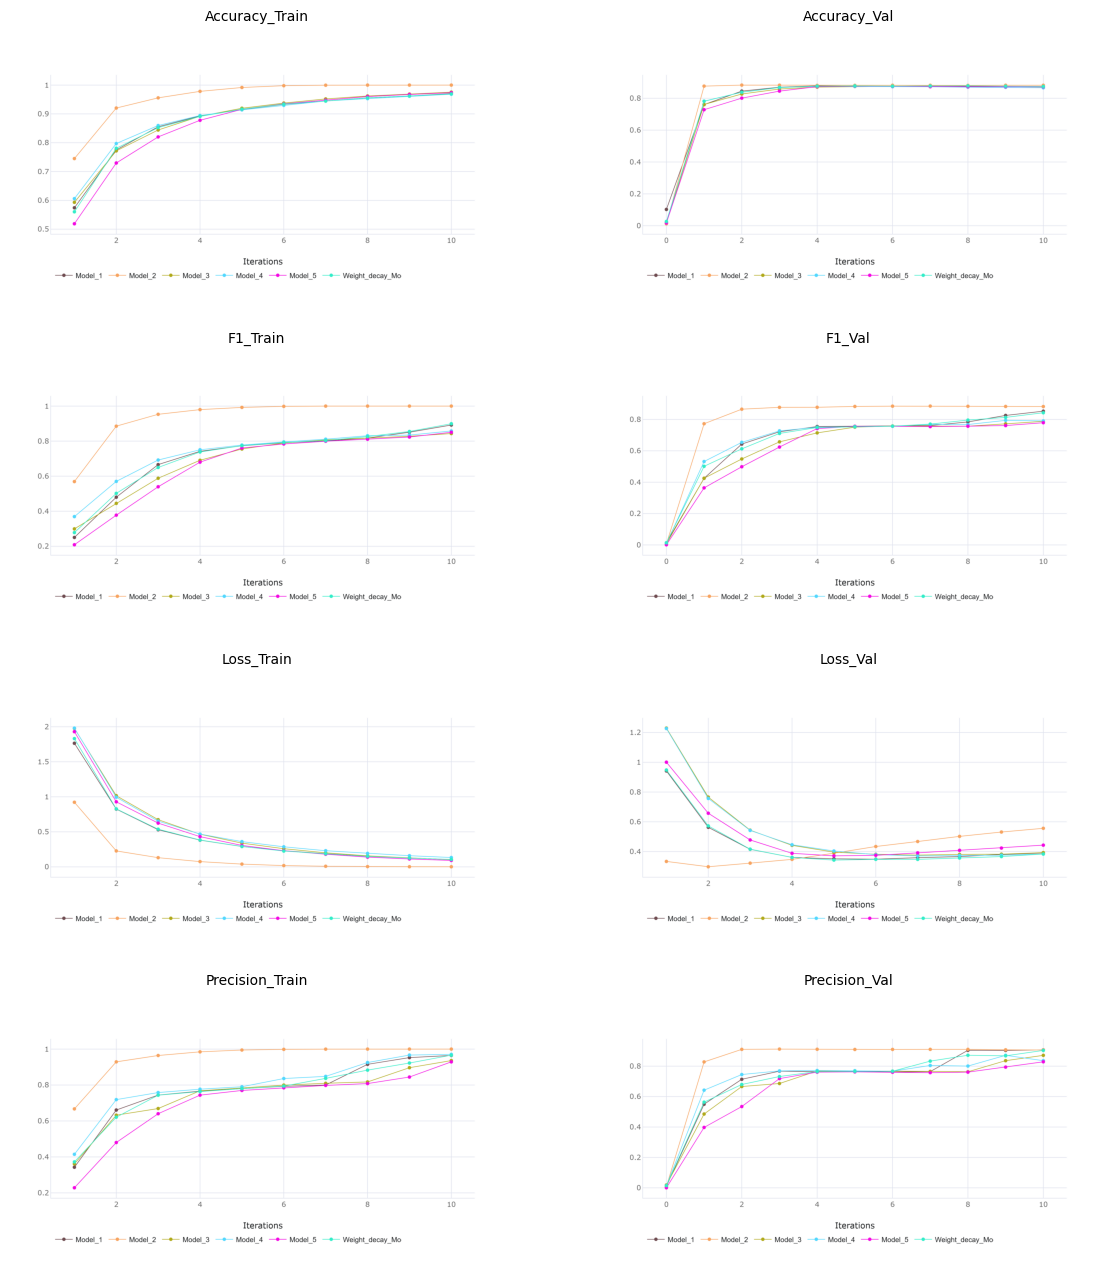

In [ ]:
show_images_grid("Plots")

### As we can see the model without batch normalization and dropout achieve the highest metrics the fastest but at the same time it also overfits to the data the most. The specific value for dropout does not seem to have very significant effect. Same for number of hidden layers. As we already struggle with overfitting it does not seem necessary to try out more sophisticated architectures. Finally we can see that using weight decay can somehow help with overfitting. In the end I decided to select model with 3 hidden layers with size [512, 256, 128] and dropout 0.5 and batch norm and weight decay